# Asteroid Classification
This notebook contains a jupyter notebook to train and test a dense neural network for classifying asteroids as hazardous or not. Because of data imbalance, in testing the network only achieved about 75% binary accuracy, however a much greater percentage of these were false positive than negatives.

In [33]:
import tensorflow as tf 
from tensorflow import keras 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import requests
import io
import os
import tempfile

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

relative_velocity_flag = False
miss_distance_flag = False

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

### Data Preprocessing

In [2]:
csv_link = 'https://raw.githubusercontent.com/sdsc-hpc-students/REHS2022/main/Final-Project/ExtraKGs/celesital-bodies/neo_v2.csv'
csv_file = requests.get(csv_link).content
dataset = pd.read_csv(io.StringIO(csv_file.decode('utf-8')))

In [3]:
change_to_float = {column:float for column, dtype in zip(dataset.columns.tolist(), dataset.dtypes.tolist()) if dtype == np.bool_}
dataset = dataset.astype(change_to_float)
dataset.head()

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
0,2162635,162635 (2000 SS164),1.198271,2.679415,13569.249224,5.483974e+07,Earth,0.0,16.73,0.0
1,2277475,277475 (2005 WK4),0.265800,0.594347,73588.726663,6.143813e+07,Earth,0.0,20.00,1.0
2,2512244,512244 (2015 YE18),0.722030,1.614507,114258.692129,4.979872e+07,Earth,0.0,17.83,0.0
3,3596030,(2012 BV13),0.096506,0.215794,24764.303138,2.543497e+07,Earth,0.0,22.20,0.0
4,3667127,(2014 GE35),0.255009,0.570217,42737.733765,4.627557e+07,Earth,0.0,20.09,1.0


In [4]:
neg, pos = np.bincount(dataset['hazardous'])
total = neg + pos
print(f"Percent positive is {(pos / neg) * 100} %")

Percent positive is 10.781013707985755 %


In [5]:
try:
    dataset_processed = dataset.drop(['sentry_object','orbiting_body'], axis=1)
except (AttributeError, KeyError):
    print("already removed")

In [6]:
dataset_processed.head()

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous
0,2162635,162635 (2000 SS164),1.198271,2.679415,13569.249224,5.483974e+07,16.73,0.0
1,2277475,277475 (2005 WK4),0.265800,0.594347,73588.726663,6.143813e+07,20.00,1.0
2,2512244,512244 (2015 YE18),0.722030,1.614507,114258.692129,4.979872e+07,17.83,0.0
3,3596030,(2012 BV13),0.096506,0.215794,24764.303138,2.543497e+07,22.20,0.0
4,3667127,(2014 GE35),0.255009,0.570217,42737.733765,4.627557e+07,20.09,1.0


In [7]:
def scale_down(dataset=None, column=None):
    initial_range = np.amax(dataset[column]) - np.amin(dataset[column])
    eps = 0.001
    dataset[column] = np.log(dataset[column] + eps)
    end_range = np.amax(dataset[column]) - np.amin(dataset[column])

    return initial_range, end_range

In [8]:
if not relative_velocity_flag:
    initial_range, end_range = scale_down(column='miss_distance', dataset=dataset_processed)
    relative_velocity_flag = True
else:
    print("scaling already complete")

print(f'Initial_range: {initial_range}\nend_range: {end_range}')

if not miss_distance_flag:
    initial_range, end_range = scale_down(column='relative_velocity', dataset=dataset_processed)
    miss_distance_flag = True
else:
    print("scaling already complete")

print(f'Initial_range: {initial_range}\nend_range: {end_range}')

Initial_range: 74791905.91968124
end_range: 9.313674550575696
Initial_range: 236786.78165533658
end_range: 7.060857763424829


In [9]:
scaler = StandardScaler()
train_data, test_data = train_test_split(dataset_processed.drop(['id', 'name'], axis=1), test_size=0.1)
_, regurgitate_data = train_test_split(dataset, test_size=0.1)
train_data, validation_data = train_test_split(train_data, test_size=0.1)

train_labels, test_labels, validation_labels = (np.array(train_data.pop('hazardous')),
                                                np.array(test_data.pop('hazardous')), 
                                                np.array(validation_data.pop('hazardous')))
bool_train_labels = train_labels != 0
train_features, test_features, validation_features = (np.clip(scaler.fit_transform(np.array(train_data)), 0, 60),
                                                      np.clip(scaler.fit_transform(np.array(test_data)), 0, 60), 
                                                      np.clip(scaler.fit_transform(np.array(validation_data)), 0, 60))

### Model Creation

In [10]:
model_metrics = [keras.metrics.BinaryAccuracy(),
                       keras.metrics.Precision(),
                       keras.metrics.Recall(),
                       keras.metrics.TruePositives(),
                       keras.metrics.TrueNegatives(),
                       keras.metrics.FalseNegatives(),
                       keras.metrics.FalsePositives(),
                       keras.metrics.AUC(name='auc'),
                       keras.metrics.AUC(name='prc', curve='PR')
                       ]

In [11]:
def make_model(metrics=model_metrics, output_bias=None):
    if output_bias:
        output_bias = tf.keras.initializers.Constant(output_bias)
    
    model = tf.keras.Sequential([
        keras.layers.Dense(5, activation='relu', input_shape=(train_features.shape[-1],), 
                            kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-4)),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(5, activation='linear', activity_regularizer=keras.regularizers.L1(0.0002)),
        keras.layers.Dense(5, activation='relu',
                            kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-4)),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(3, activation='linear', activity_regularizer=keras.regularizers.L1(0.0002)),
        keras.layers.Dense(3, activation='relu',
                            kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-4)),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics
    )
    
    return model

In [12]:
# epochs, batch size, and early stopping
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc',
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True
)

# Setting the initial bias
initial_bias = np.log([pos/neg])
model = make_model(output_bias=initial_bias)
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

In [13]:
# classification weights
weight_for_0 = (1 / neg) * (total / 2)
weight_for_1 = (1 / pos) * (total / 2)

class_weights = {0: weight_for_0, 1: weight_for_1}

print(f'Non-Hazardous Weight: {weight_for_0}\nHazardous Weight: {weight_for_1}')

Non-Hazardous Weight: 0.5539050685399288
Hazardous Weight: 5.137782805429865


In [14]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)
weighted_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 5)                 30        
                                                                 
 dropout_3 (Dropout)         (None, 5)                 0         
                                                                 
 dense_7 (Dense)             (None, 5)                 30        
                                                                 
 dense_8 (Dense)             (None, 5)                 30        
                                                                 
 dropout_4 (Dropout)         (None, 5)                 0         
                                                                 
 dense_9 (Dense)             (None, 3)                 18        
                                                                 
 dense_10 (Dense)            (None, 3)                

In [15]:
weighted_history = weighted_model.fit(train_features, 
                    train_labels, 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, 
                    callbacks=[early_stopping], 
                    validation_data=(validation_features, validation_labels), 
                    class_weight=class_weights)

Epoch 1/100
36/36 [==============================] - 12s 114ms/step - loss: 1.2074 - binary_accuracy: 0.9021 - precision: 0.5000 - recall: 1.3887e-04 - true_positives: 1.0000 - true_negatives: 66374.0000 - false_negatives: 7200.0000 - false_positives: 1.0000 - auc: 0.4897 - prc: 0.0944 - val_loss: 0.3256 - val_binary_accuracy: 0.9008 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_true_positives: 0.0000e+00 - val_true_negatives: 7365.0000 - val_false_negatives: 811.0000 - val_false_positives: 0.0000e+00 - val_auc: 0.4421 - val_prc: 0.0856
Epoch 2/100
36/36 [==============================] - 1s 14ms/step - loss: 1.1352 - binary_accuracy: 0.9018 - precision: 0.2308 - recall: 0.0012 - true_positives: 9.0000 - true_negatives: 66345.0000 - false_negatives: 7192.0000 - false_positives: 30.0000 - auc: 0.5260 - prc: 0.1128 - val_loss: 0.3296 - val_binary_accuracy: 0.9002 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_true_positives: 0.0000e+00 - val_true_negatives: 7360.

In [16]:
weighted_model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE, verbose=1)

5/5 [==============================] - 0s 8ms/step - loss: 0.3852 - binary_accuracy: 0.7370 - precision: 0.2475 - recall: 0.9239 - true_positives: 765.0000 - true_negatives: 5930.0000 - false_negatives: 63.0000 - false_positives: 2326.0000 - auc: 0.8778 - prc: 0.3355


[0.38521215319633484,
 0.73701012134552,
 0.247492715716362,
 0.9239130616188049,
 765.0,
 5930.0,
 63.0,
 2326.0,
 0.8777711391448975,
 0.33549684286117554]

In [17]:
results = weighted_model.predict(test_features)
results[results<0.5]=0
results[results>0.5]=1

284/284 [==============================] - 1s 3ms/step


In [18]:
len(results)

9084

In [19]:
regurgitate_data['predicted_values'] = results

In [20]:
def prediction_classification(input_set):
    if all(input_set):
        return "True_Positive"
    elif not input_set[0] and input_set[1]:
        return "False_Positive"
    elif not input_set[0] and not input_set[1]:
        return "True_Negative"
    else:
        return "False_Negative"

In [21]:
def boolean_transformer(input_set, positive_identifier, negative_identifier):
    input_set[input_set == 0] = negative_identifier
    input_set[input_set == 1] = positive_identifier

    return input_set 

In [22]:
regurgitate_data['Classification_Success'] = \
list(map(prediction_classification, list(zip(regurgitate_data['hazardous'], regurgitate_data['predicted_values']))))

In [23]:
regurgitate_data['hazardous'] = boolean_transformer(regurgitate_data['hazardous'], 'hazardous', 'not_hazardous')
regurgitate_data['predicted_values'] = boolean_transformer(regurgitate_data['predicted_values'], 'predicted_hazardous', 'predicted_not_hazardous')

C:\Users\ahuma\AppData\Local\Temp/ipykernel_12916/329045822.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_set[input_set == 0] = negative_identifier
C:\Users\ahuma\AppData\Local\Temp/ipykernel_12916/329045822.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_set[input_set == 1] = positive_identifier


In [24]:
regurgitate_data.head()

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous,predicted_values,Classification_Success
67573,3785695,(2017 TO2),0.058151,0.130029,87664.855672,6.102192e+07,Earth,0.0,23.30,not_hazardous,predicted_not_hazardous,True_Negative
43657,54239834,(2022 BA1),0.081013,0.181151,78299.267215,4.698217e+07,Earth,0.0,22.58,not_hazardous,predicted_not_hazardous,True_Negative
36033,3837686,(2019 AX5),0.016771,0.037501,50329.784504,4.706466e+07,Earth,0.0,26.00,not_hazardous,predicted_hazardous,False_Positive
72869,3749030,(2016 GG2),0.105817,0.236614,50936.691501,4.755413e+07,Earth,0.0,22.00,not_hazardous,predicted_not_hazardous,True_Negative
72037,3729536,(2015 TX143),0.296862,0.663804,80524.971847,3.898925e+07,Earth,0.0,19.76,not_hazardous,predicted_not_hazardous,True_Negative


In [25]:
regurgitate_data.head()

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous,predicted_values,Classification_Success
67573,3785695,(2017 TO2),0.058151,0.130029,87664.855672,6.102192e+07,Earth,0.0,23.30,not_hazardous,predicted_not_hazardous,True_Negative
43657,54239834,(2022 BA1),0.081013,0.181151,78299.267215,4.698217e+07,Earth,0.0,22.58,not_hazardous,predicted_not_hazardous,True_Negative
36033,3837686,(2019 AX5),0.016771,0.037501,50329.784504,4.706466e+07,Earth,0.0,26.00,not_hazardous,predicted_hazardous,False_Positive
72869,3749030,(2016 GG2),0.105817,0.236614,50936.691501,4.755413e+07,Earth,0.0,22.00,not_hazardous,predicted_not_hazardous,True_Negative
72037,3729536,(2015 TX143),0.296862,0.663804,80524.971847,3.898925e+07,Earth,0.0,19.76,not_hazardous,predicted_not_hazardous,True_Negative


In [26]:
regurgitate_data.to_csv(path_or_buf=r'C:\Users\ahuma\Desktop\python projects\REHS2022\Final-Project\ExtraKGs\celesital-bodies\processed_data.csv', index=False)

In [27]:
#keras.backend.clear_session()

Plotting

In [46]:
def plot_loss(history, n):
    plt.semilogy(history.epoch, history.history['loss'],
                 color=colors[n], label='Training set loss')
    plt.semilogy(history.epoch, history.history['val_loss'],
                 color=colors[n], label='Validation set loss', linestyle="--")
    plt.title('Training Loss vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

In [75]:
def plot_metrics(history, metrics):
    if len(metrics) > 4:
        metrics = metrics[:3]
    elif len(metrics) < 4:
        raise Exception("Must be a list greater or equal to length 4")

    plt.subplots(figsize=(8,8))
    plt.subplots_adjust(left=0.1,
                            bottom=0.1,
                            right=0.9,
                            top=0.9,
                            wspace=0.4,
                            hspace=0.4)
    for n, metric in enumerate(metrics):
        name = metric.replace("_", " ")
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label="Training Dataset")
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Validation Dataset')
        plt.xlabel('Epoch')
        plt.ylabel(name)
    
        plt.legend()

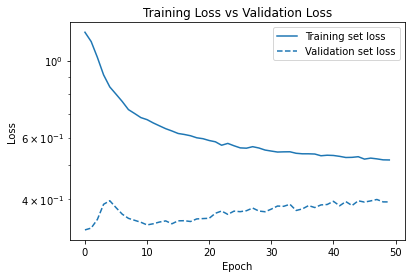

In [47]:
plot_loss(weighted_history, 0)

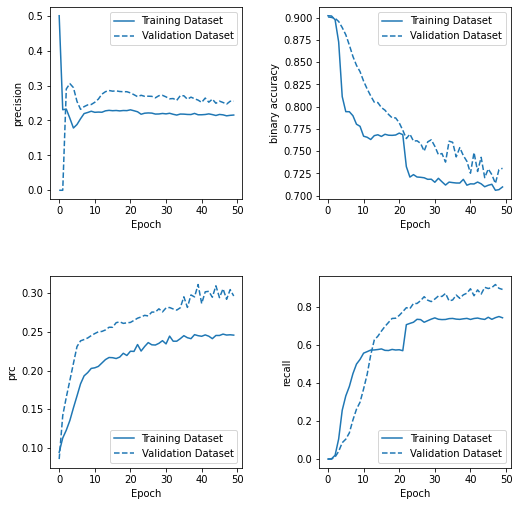

In [77]:
plot_metrics(weighted_history, ['precision', 'binary_accuracy', 'prc', 'recall'])